In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   zoom_range=-0.2, # zoom into the image
                                   width_shift_range=0.2, # shift the image width ways
                                   height_shift_range=0.2) # shift the image height ways

In [6]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# one hot encode target values
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train.astype('float32')
X_test.astype('float32')

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [7]:
X_train_aug = train_datagen.fit(X_train)

ValueError: too many values to unpack (expected 2)

<Figure size 432x288 with 0 Axes>

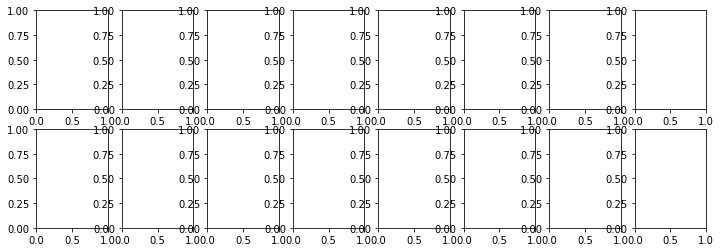

In [8]:
num_row = 2
num_col = 8
num = num_row*num_col
plt.figure()
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for x, y in train_datagen.flow(X_train, batch_size=num, shuffle=True):
    for i in range(0, num):
        ax = axes2[i//num_col, i%num_col]
        ax.imshow(x[i].reshape(28,28), cmap='gray_r')
        ax.set_title('Label: {}'.format(int(y[i])))
    break

# show the figure
plt.tight_layout()
plt.show()

In [8]:
X_train.shape , y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1),
                 padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

2022-05-27 14:52:03.051351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 14:52:03.073416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karol/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-05-27 14:52:03.075835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping re

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                        

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))


Epoch 1/10
235/235 [==============================] - 33s 138ms/step - loss: 0.4742 - accuracy: 0.8553 - val_loss: 0.0793 - val_accuracy: 0.9759
Epoch 2/10
235/235 [==============================] - 33s 139ms/step - loss: 0.1504 - accuracy: 0.9556 - val_loss: 0.0568 - val_accuracy: 0.9825
Epoch 3/10
235/235 [==============================] - 32s 136ms/step - loss: 0.1130 - accuracy: 0.9668 - val_loss: 0.0447 - val_accuracy: 0.9867
Epoch 4/10
235/235 [==============================] - 32s 136ms/step - loss: 0.0957 - accuracy: 0.9717 - val_loss: 0.0421 - val_accuracy: 0.9869
Epoch 5/10
235/235 [==============================] - 32s 137ms/step - loss: 0.0844 - accuracy: 0.9745 - val_loss: 0.0373 - val_accuracy: 0.9880
Epoch 6/10
235/235 [==============================] - 32s 137ms/step - loss: 0.0757 - accuracy: 0.9766 - val_loss: 0.0371 - val_accuracy: 0.9882
Epoch 7/10
235/235 [==============================] - 32s 135ms/step - loss: 0.0681 - accuracy: 0.9792 - val_loss: 0.0368 - val_ac

Text(0.5, 0, 'epochs')

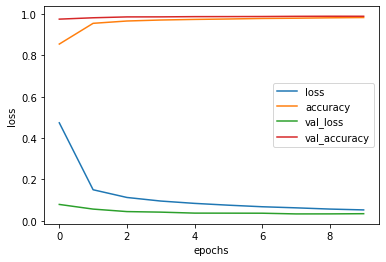

In [12]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [13]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0345 - accuracy: 0.9898


[0.03452508896589279, 0.989799976348877]

In [14]:
model.save("model.h5")